In [285]:
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [370]:
X, y = make_moons(n_samples = 10000, noise = 0.4, random_state=42)
df = pd.DataFrame(np.c_[X,y], columns = ["x1","x2","target"])
df.head()

,x1,x2,target
0,0.940291,0.122306,1.0
1,0.124540,-0.424775,0.0
2,0.261988,0.508414,0.0
3,-0.495238,0.072589,0.0
4,-0.879413,0.549373,0.0


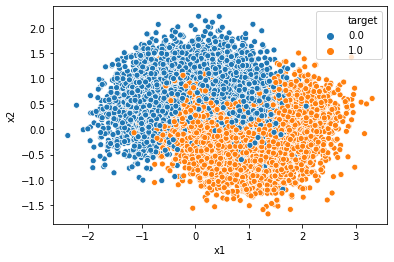

In [371]:
sn.scatterplot(x="x1", y="x2", hue = "target", data=df)

In [288]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [298]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)

# hyperparameter tuning for Random Forests
param_grid =[{'min_samples_split': [2, 5, 10],'min_samples_leaf': [2,3,4],
             'max_leaf_nodes': list(range(2,20))
            }      
]

# train across 5 folds, that's a total of 30*5=150 rounds of training 
grid_search = GridSearchCV(tree_clf, param_grid, cv=3,
                           scoring='accuracy',
                           return_train_score=True,
                           verbose=1)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:    3.9s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19],
                          'min_samples_leaf': [2, 3, 4],
                          'min_samples_split': [2, 5, 10]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [297]:
# report optimisation results
print(grid_search.best_params_)
print(grid_search.best_score_)
best_estimator = grid_search.best_estimator_

{'max_leaf_nodes': 16, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.8564


In [291]:
predictions = best_estimator.predict(x_test)

In [292]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions,y_test)

0.8648

In [293]:
#Visualisation tool for tree (requires installation of external library)

from sklearn.tree import export_graphviz

export_graphviz(
        best_estimator,
        out_file="moons_tree.dot",
)

**Train manually a Random Forest classifier**

In [361]:
from sklearn.base import clone
num_examples = 100
num_subsets = 1000
trees = [clone(best_estimator) for _ in range(num_subsets)]
accuracies = []; preds = []
rng = np.random.default_rng()   # initialise shuffling object
inds = np.arange(len(y_train))  # list of dataset indices
for tree in trees:
    rng.shuffle(inds)
    train_idx = np.random.choice(inds, size=num_examples, replace=False)
    tree.fit(x_train[train_idx], y_train[train_idx])
    pred = tree.predict(x_test)
    preds.append(list(pred))
    accuracies.append(accuracy_score(pred,y_test))

In [368]:
np.mean(accuracies)

0.7962683999999999

{'whiskers': [<matplotlib.lines.Line2D at 0x150ae628>,
 'caps': [<matplotlib.lines.Line2D at 0x150ae670>,
 'boxes': [<matplotlib.lines.Line2D at 0x20b576a0>],
 'medians': [<matplotlib.lines.Line2D at 0x15022a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x15022fb8>],
 'means': []}

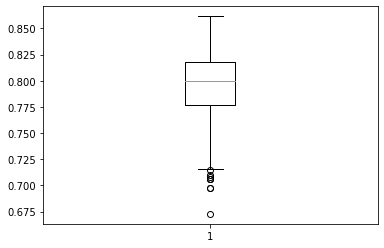

In [364]:
plt.boxplot(accuracies)

In [369]:
#Get majority vote for each test set sample (using statistical mode)

from scipy.stats import mode

majority_vote = mode(np.transpose(np.array(preds)),axis=1)
accuracy_score(majority_vote[0],y_test)

0.8644

**Equivalent class implentation in Scikit**

In [390]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 1000,
    max_samples=100, bootstrap = True, n_jobs=-1
)

bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

In [391]:
accuracy_score(y_pred,y_test)

0.866